In [ ]:
import pandas as pd

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import load_model

from keras_tuner import Hyperband

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/motion.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61390 entries, 0 to 61389
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   roll       61390 non-null  float64
 1   pitch      61390 non-null  float64
 2   yaw        61390 non-null  float64
 3   gravity_x  61390 non-null  float64
 4   gravity_y  61390 non-null  float64
 5   gravity_z  61390 non-null  float64
 6   rot_x      61390 non-null  float64
 7   rot_y      61390 non-null  float64
 8   rot_z      61390 non-null  float64
 9   acc_x      61390 non-null  float64
 10  acc_y      61390 non-null  float64
 11  acc_z      61390 non-null  float64
 12  motion     61390 non-null  int64  
dtypes: float64(12), int64(1)
memory usage: 6.1 MB


In [3]:
df.head()

,roll,pitch,yaw,gravity_x,gravity_y,gravity_z,rot_x,rot_y,rot_z,acc_x,acc_y,acc_z,motion
0,-0.016713,-0.014669,-0.000690,0.000256,-0.000292,1.000000,0.223029,0.261799,-0.346268,7.220912,7.053318,2.169147,1
1,-9.288085,-9.079309,-0.339972,0.157802,-0.159376,0.974524,-0.414482,-1.817274,-1.075842,13.433870,8.283937,-0.732626,1
2,-8.256960,-6.955922,0.915470,0.121106,-0.142556,0.982350,0.410486,0.546115,0.411951,4.917690,5.099649,1.683124,1
3,-10.831960,-5.068473,2.593315,0.088346,-0.187194,0.978342,-0.882923,0.582221,2.106386,2.248155,5.947197,3.500323,1
4,-10.040980,-4.582554,0.992040,0.079895,-0.173795,0.981536,-0.256870,1.358292,0.588083,11.719620,16.347610,1.170765,1


In [4]:
df.describe()

,roll,pitch,yaw,gravity_x,gravity_y,gravity_z,rot_x,rot_y,rot_z,acc_x,acc_y,acc_z,motion
count,61390.000000,61390.000000,61390.000000,61390.000000,61390.000000,61390.000000,61390.000000,61390.000000,61390.000000,61390.000000,61390.000000,61390.000000,61390.000000
mean,-0.611711,0.138762,0.002561,-0.002415,-0.010642,0.999286,0.035702,0.003423,0.023649,-0.574877,1.072524,6.853876,0.562958
std,1.202391,1.693387,0.139703,0.029453,0.020783,0.003119,0.600786,0.616529,0.689295,5.022737,3.705045,4.524918,0.496024
min,-13.092140,-11.659080,-4.022047,-0.213288,-0.226201,0.968753,-4.365721,-4.365721,-4.365721,-19.613300,-19.613300,-12.164940,0.000000
25%,-0.875665,-1.129592,-0.012170,-0.019926,-0.015280,0.999782,-0.058322,-0.079672,-0.094594,-1.529895,-0.344765,3.612850,0.000000
50%,-0.314617,0.585392,0.001756,-0.010217,-0.005489,0.999788,0.033175,0.011058,0.019985,-0.184354,0.608127,9.186552,1.000000
75%,-0.099469,1.141755,0.015829,0.019714,-0.001736,0.999793,0.113080,0.100590,0.146554,0.873884,2.216432,9.435549,1.000000
max,0.225945,12.315100,4.187518,0.202088,0.003943,1.000000,4.365588,4.365588,4.365588,19.612700,19.612700,19.612700,1.000000


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('motion', axis=1),
    df['motion'],
    test_size=0.15,
    random_state=42,
    stratify=df['motion']
)

In [6]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(52181, 12) (9209, 12) (52181,) (9209,)


In [14]:
def build_model(hp):

    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))

    for i in range(hp.Int('num_layers_1', 3, 8)):
        model.add(Dense(
            units=hp.Int(f'units_{i}', min_value=8, max_value=256, step=16),
            activation='relu'
        ))
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=Adam(learning_rate=hp.Choice('adam_lr', [0.01, 0.001])), loss=BinaryCrossentropy(), metrics=['accuracy'])
    
    return model

In [15]:
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=5,
    directory='tuner',
    project_name='motion_recognition_v1'
)

tuner.search(X_train, y_train, validation_data=(X_test, y_test))

Trial 10 Complete [00h 00m 13s]
val_accuracy: 0.9540666937828064

Best val_accuracy So Far: 0.9652513861656189
Total elapsed time: 00h 01m 38s


In [16]:
model = tuner.get_best_models(num_models=1)[0]
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 104       
                                                                 
 dense_1 (Dense)             (None, 120)               1080      
                                                                 
 dense_2 (Dense)             (None, 40)                4840      
                                                                 
 dense_3 (Dense)             (None, 1)                 41        
                                                                 
Total params: 6065 (23.69 KB)
Trainable params: 6065 (23.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
history = model.fit(X_train, y_train, epochs=15, validation_data=(X_test, y_test))

Epoch 1/15
1631/1631 [==============================] - 3s 2ms/step - loss: 0.1023 - accuracy: 0.9631 - val_loss: 0.0957 - val_accuracy: 0.9645
Epoch 2/15
1631/1631 [==============================] - 2s 1ms/step - loss: 0.0964 - accuracy: 0.9650 - val_loss: 0.0899 - val_accuracy: 0.9674
Epoch 3/15
1631/1631 [==============================] - 2s 1ms/step - loss: 0.0963 - accuracy: 0.9654 - val_loss: 0.0896 - val_accuracy: 0.9663
Epoch 4/15
1631/1631 [==============================] - 2s 1ms/step - loss: 0.0938 - accuracy: 0.9654 - val_loss: 0.1002 - val_accuracy: 0.9629
Epoch 5/15
1631/1631 [==============================] - 2s 1ms/step - loss: 0.0924 - accuracy: 0.9661 - val_loss: 0.0836 - val_accuracy: 0.9688
Epoch 6/15
1631/1631 [==============================] - 2s 1ms/step - loss: 0.0919 - accuracy: 0.9660 - val_loss: 0.0848 - val_accuracy: 0.9686
Epoch 7/15
1631/1631 [==============================] - 2s 1ms/step - loss: 0.0895 - accuracy: 0.9667 - val_loss: 0.0888 - val_accuracy:

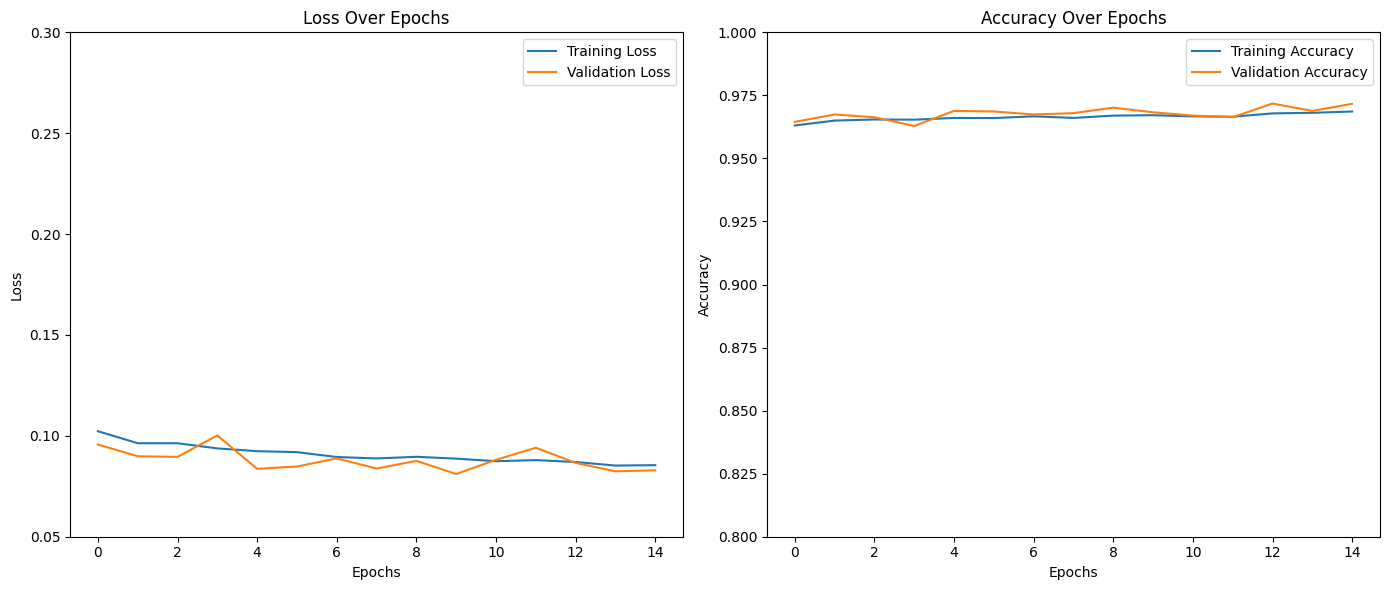

In [23]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].plot(train_loss, label='Training Loss')
axs[0].plot(val_loss, label='Validation Loss')
axs[0].set_title('Loss Over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim(0.05, 0.3)
axs[0].legend()

axs[1].plot(train_acc, label='Training Accuracy')
axs[1].plot(val_acc, label='Validation Accuracy')
axs[1].set_title('Accuracy Over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim(0.8, 1.0)
axs[1].legend()

plt.tight_layout()
plt.show()

In [24]:
model_name = 'MotionNetV1'

model.save(f'model/{model_name}.keras')
model = load_model(f'model/{model_name}.keras')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open(f'model/{model_name}.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\tailw\AppData\Local\Temp\tmp4nw7yidp\assets


INFO:tensorflow:Assets written to: C:\Users\tailw\AppData\Local\Temp\tmp4nw7yidp\assets
